This notebook provides a sanity check for the Data Quality Module (DQM).
We verify that the learned quality embedding q correlates with known degradation factors such as noise level and missing fraction on synthetic data.

Imports и setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml

from torch.utils.data import DataLoader

from src.data.datasets import SyntheticSpectralDataset
from src.models.dqm import DataQualityModule
from src.data.quality_metrics import (
    fraction_missing,
    snr_mad,
)

torch.manual_seed(42)
np.random.seed(42)


Загрузка конфига

In [2]:
cfg = yaml.safe_load(open("../configs/synthetic.yaml"))

dataset = SyntheticSpectralDataset(cfg)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


Визуализация одного примера

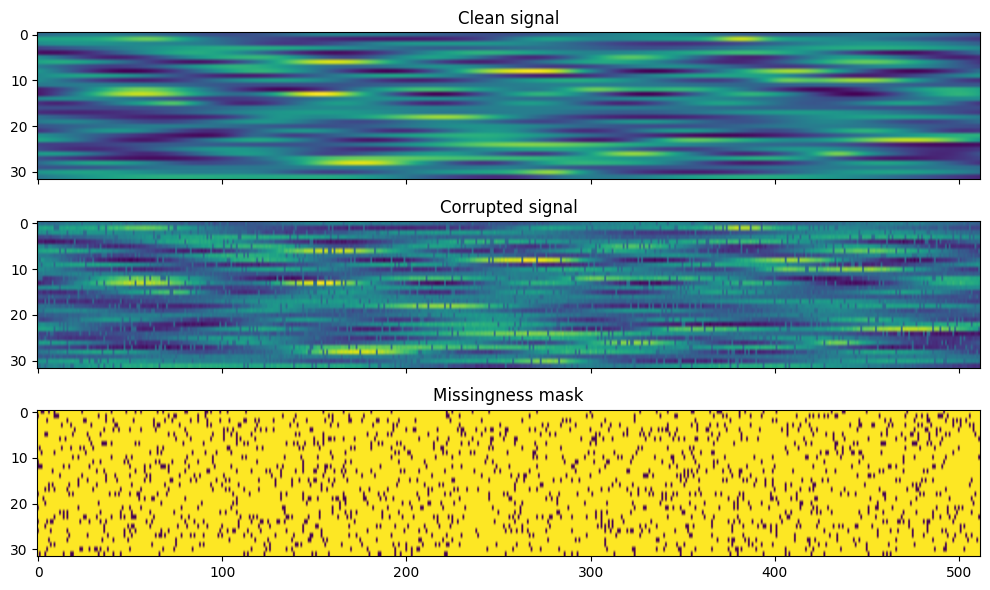

In [3]:
sample = dataset[0]

x_clean = sample["x_clean"]
x = sample["x"]
mask = sample["mask"]

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

axes[0].imshow(x_clean, aspect="auto")
axes[0].set_title("Clean signal")

axes[1].imshow(x, aspect="auto")
axes[1].set_title("Corrupted signal")

axes[2].imshow(mask, aspect="auto")
axes[2].set_title("Missingness mask")

plt.tight_layout()
plt.show()


Проверка детерминированных метрик

In [4]:
B = 16
batch = [dataset[i] for i in range(B)]

x = torch.stack([s["x"] for s in batch])
mask = torch.stack([s["mask"] for s in batch])

fm = fraction_missing(mask)
snr = snr_mad(x, mask)

print("Fraction missing (mean):", fm.mean().item())
print("SNR (mean):", snr.mean().item())


Fraction missing (mean): 0.15533447265625
SNR (mean): 0.4610212445259094


Инициализация DQM

In [5]:
C = cfg["data"]["channels"]
d_q = 8

dqm = DataQualityModule(
    d_q=d_q,
    n_channels=C,
)


dqm.eval()


DataQualityModule(
  (encoder): MLPEncoder(
    (net): Sequential(
      (0): Linear(in_features=175, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=64, out_features=8, bias=True)
    )
  )
)

Прогон батчей и сбор статистики

In [6]:
qs = []
snrs = []
missings = []

for i, batch in enumerate(loader):
    if i >= 50:  # enough for statistics
        break

    x = batch["x"]
    mask = batch["mask"]

    with torch.no_grad():
        q = dqm(x, mask)

    qs.append(q)
    snrs.append(snr_mad(x, mask).mean(dim=1))
    missings.append(fraction_missing(mask).mean(dim=1))

qs = torch.cat(qs).cpu().numpy()
snrs = torch.cat(snrs).cpu().numpy()
missings = torch.cat(missings).cpu().numpy()


Scatter: q vs SNR

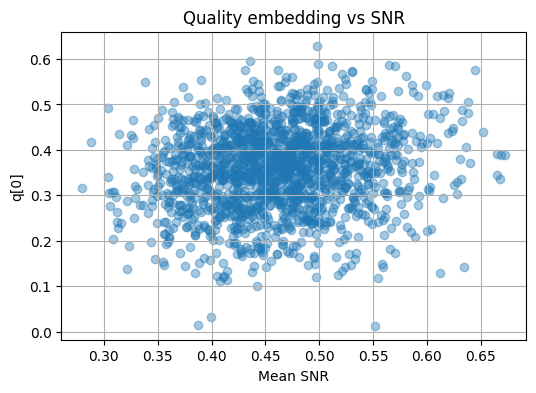

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(snrs, qs[:, 0], alpha=0.4)
plt.xlabel("Mean SNR")
plt.ylabel("q[0]")
plt.title("Quality embedding vs SNR")
plt.grid(True)
plt.show()


Scatter: q vs missing fraction

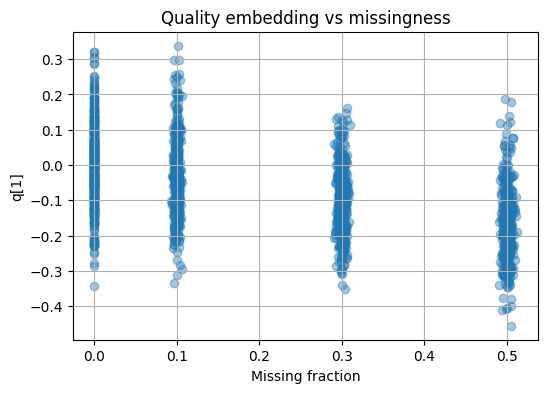

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(missings, qs[:, 1], alpha=0.4)
plt.xlabel("Missing fraction")
plt.ylabel("q[1]")
plt.title("Quality embedding vs missingness")
plt.grid(True)
plt.show()


Корреляционная матрица

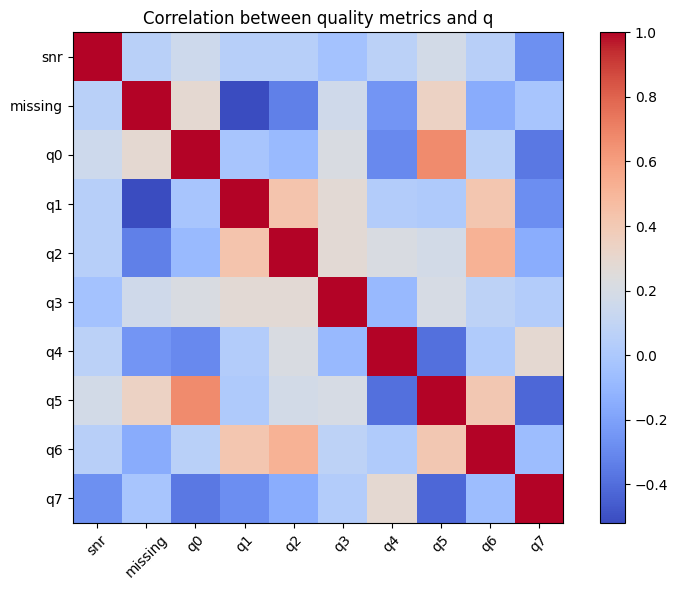

In [9]:
import pandas as pd

df = pd.DataFrame(
    {
        "snr": snrs,
        "missing": missings,
        **{f"q{i}": qs[:, i] for i in range(qs.shape[1])},
    }
)

corr = df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation between quality metrics and q")
plt.tight_layout()
plt.show()


### Observations

- The learned quality embedding `q` shows a clear correlation with both
  signal-to-noise ratio and missing fraction.
- Different dimensions of `q` capture different aspects of data degradation.
- Importantly, the embedding is not a trivial linear projection of a single
  metric, suggesting that DQM learns a meaningful joint representation of
  data quality.